### Step 1: Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Step 2: Loading the CIFAR-10 Data

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [7]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 32, 32]) 
Label: 6


### Step 3: Loading Batches With Dataloader

In [12]:
torch.manual_seed(100)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Step 4: Defining the Strings for Labels

In [13]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### Step 5: Viewing the Dataset

Label: [    3     1     4     6     6     6     6     2     9     0]
Class:    cat   car  deer  frog  frog  frog  frog  bird truck plane


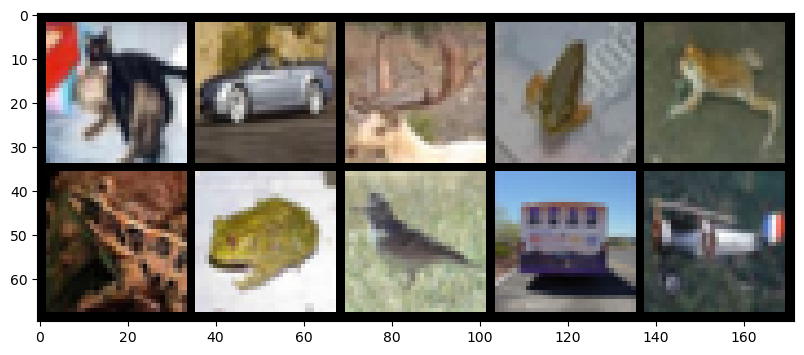

In [14]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Step 6: Defining the Convolutional Neural Network Class

In [26]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten
        # Defining the convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Defining the fully connted layers
        self.fc1 = nn.Linear(6*6*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    # Defining the forward propagation
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [27]:
torch.manual_seed(100)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Step 7: Count the Model Parameters

In [28]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [29]:
count_parameters(model)

   162
     6
   864
    16
 73728
   128
  8192
    64
   640
    10
______
 83810


### Step 8: Defining the Loss Function and the Optimizer

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Step 9: Training the Model

In [31]:
import time 

start_time = time.time()

epochs = 50
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Employing our CNN model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tallying the correct number of predictions 
        predicted = torch.max(y_pred.detach(), 1)[1]
        trn_corr += (predicted == y_train).sum() # Counts the number of right predictions in a batch

        # Updating the parameters using gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
    # Updating the loss and data accuracy for each epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Now for the testing data
    with torch.inference_mode():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Employing our CNN model
            y_val = model(X_test)

            # Tallying the correct number of predictions 
            predicted = torch.max(y_val.detach(), 1)[1]
            tst_corr += (predicted == y_test).sum()

        # Updating the loss and data accuracy for each epoch
        loss = criterion(y_val, y_test)
        test_losses.append(loss.item())
        test_correct.append(tst_corr.item())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.40115654              accuracy:  25.670%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.35171580              accuracy:  32.245%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.56978428              accuracy:  36.137%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.65527749              accuracy:  38.803%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.61912501              accuracy:  40.796%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.21733117              accuracy:  51.350%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 2.33501577              accuracy:  51.555%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.25698125              accuracy:  51.953%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.34754205              accuracy:  52.250%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.48272622              accuracy:  52.832%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.43119144              accuracy:  56.110%
epoch:  2  batch: 2000 [ 20000/5

### Step 10: Saving the Model

In [32]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

### Step 11: Plotting the Loss and Accuracy Comparions

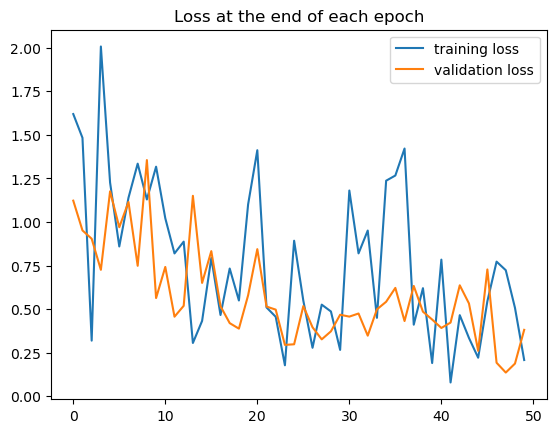

In [33]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

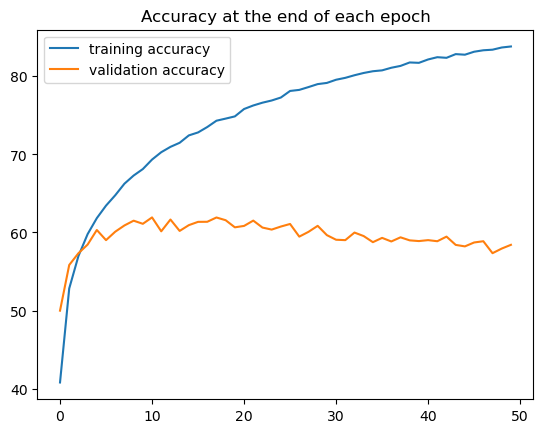

In [34]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Step 12: Evaluating Test Data

In [36]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1]*100/10000:.3f}%') # print the most recent result as a percent

[4999, 5584, 5734, 5845, 6032, 5902, 6010, 6090, 6151, 6111, 6193, 6015, 6166, 6020, 6094, 6136, 6137, 6192, 6157, 6066, 6084, 6152, 6063, 6037, 6076, 6109, 5947, 6008, 6085, 5966, 5907, 5902, 5999, 5954, 5876, 5931, 5885, 5938, 5899, 5890, 5902, 5888, 5947, 5841, 5822, 5872, 5888, 5735, 5794, 5842]

Test accuracy: 58.420%


In [37]:
test_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [42]:
with torch.inference_mode():
    correct = 0 
    for X_test, y_test in test_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.detach(), 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%') 

Test accuracy: 5842/10000 =  58.420%


### Step 13: Evaluating the Confusion Matrix

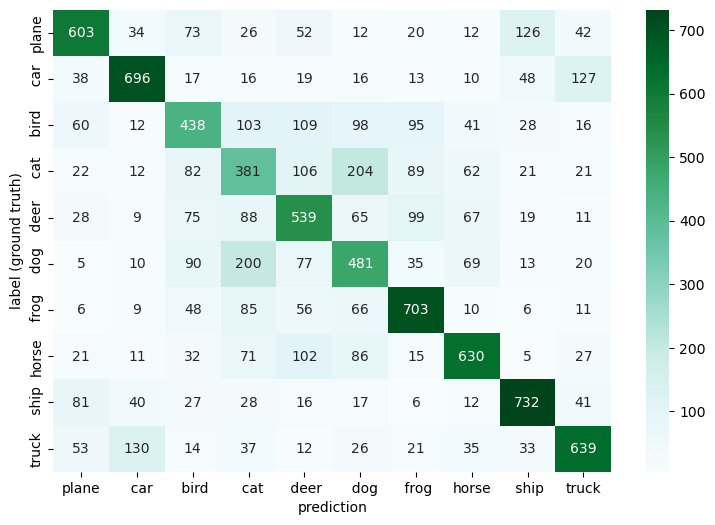

In [43]:
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

### Step 14: Examining the Misses

In [44]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

4158

In [45]:
# Display the first 8 index positions
misses[:8]

array([    0,     5,     6,    15,    20,    24,    25,    27])

In [46]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    0     5     6    15    20    24    25    27]
Label: [    3     6     1     8     7     5     2     0]
Class:    cat  frog   car  ship horse   dog  bird plane

Guess: [    5     5     2     5     9     7     3     4]
Class:    dog   dog  bird   dog truck horse   cat  deer


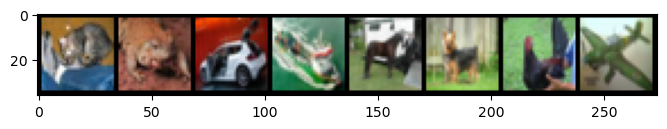

In [47]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### # Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CIFAR10-CNN-Model-master.pt'))
model2.eval()Step 15: Loading the Saved Model

In [51]:
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CIFAR10-CNN-Model.pt'))
model2.eval()

/var/folders/sc/k6080_9j4cx42wf_vh5ybvmw0000gn/T/ipykernel_38473/2898025207.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('CIFAR10-CN

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)